# Snapshot Analytics

This notebook shows how to run a Snapshot Explain operation with the minimal steps and a simple query.

In this notebook...
* [Dependencies and Initialisation](#Dependencies-and-Initialisation)
* [The Where Statement](#The-Where-Statement)
* [Load a Saved Query](#Load-a-Saved-Query)
* [Save the query for other operations](#Save-the-query-for-other-operations)
* [Analytics Query Options](#Analytics-Query-Options)
* [Running the Analytics Operation](#Running-the-Analytics-Operation)
* [Quick view of the returned Time-Series](#Quick-view-of-the-returned-Time-Series)

## Dependencies and Initialisation
Import statements and environment initialisation using the package `dotenv`. More details in the [Configuration notebook](0.2_configuration.ipynb).

In [7]:
from factiva.news import Snapshot
from dotenv import load_dotenv
load_dotenv()
print('Done!')

Done!


## The Where Statement

This notebook uses a simple query for illustration purposes. For more tips about queries, or guidance on how to build complex or large queries, checkout the [Complex and Large Queries](2.1_complex_large_queries.ipynb) notebook.

In [8]:
# Industry i3432 is for Batteries
where_statement = (
    r" publication_datetime >= '2016-01-01 00:00:00' "
    r" AND LOWER(language_code) IN ('en', 'de', 'fr') "
    r" AND REGEXP_CONTAINS(industry_codes, r'(?i)(^|,)(i3432)($|,)') "
)

s = Snapshot(query=where_statement)

## Load a Saved Query

Loads a query that was saved to a JSON file. **To be implemented!**

In [12]:
# Load saved query code

## Save the query for other operations

Implement this method!

In [1]:
# Save query code

## Analytics Query Options

An analytics job works under the same logic as the Explain job. It means that no extractions are decremented from the allowance, and results consist of a volume estimation. The analytics result allows to get a more detailed view of the used criteria in order to fine-tune the query.

In the case of analytics, the query uses more parameters to group and summarise the results:

* **`frequency`**: _Optional_, _Default: `'MONTH'`_. Frequency to aggregate results. Possible values are `'MONTH'`, `'YEAR'` or `'DAY'`. Used only by the Analytics operation.
* **`date_field`**: _Optional_, _Default: `'publication_datetime'`_. Date-time field used to aggregate. Possible values are `'publication_datetime'`, `'ingestion_datetime'` and `'modification_datetime'`. Used only by the Analytics operation.
* **`group_by_source_code`**: _Optional_, _Default: `False`_. Specifies if the results will contain only a year field (`False`), or if each year will be broken-down by source (`True`). Used only by the Analytics operation.
* **`top`**: Valid only if ```group_by_source_code``` is True. Limits the number of sources used to group the content by frequency. Used only by the Analytics operation.

**Note:**, the sum of broken-down volumes in Analytics may not add up to the total displayed with the Explains operation, as Analytics will filter estimations according to the top sources by volume.

In [9]:
s.query.frequency = 'MONTH'
s.query.date_field = 'publication_datetime'
s.query.group_by_source_code = False
s.query.top = 10

## Running the Analytics Operation

This operation returns document volume time-series matching provided query in the Factiva Analytics archive. The goal of this operation is to have a more precise idea of the document volume and time distribution. When used iteratively, helps deciding on the used criteria to add/delete/modify the criteria to verify the impact on the matching items.

The `<Snapshot>.process_analytics()` function directly returns the time-series dataset. If a more manual process is required (send job, monitor job, get results), please see the [detailed package documentation](https://factiva-news-python.readthedocs.io/).

In [10]:
%%time
s.process_analytics()
print('Done!')

Done!
CPU times: user 177 ms, sys: 13.9 ms, total: 191 ms
Wall time: 34.7 s


## Quick view of the returned Time-Series
Restuls are stored in the `<Snapshot>.last_analytics_job.data` property. It is a Pandas DataFrame with the time-series fields and values.

In [11]:
s.last_analytics_job.data

,publication_datetime,count
0,2016-01,1325
1,2016-02,1323
2,2016-03,1385
3,2016-04,1471
4,2016-05,1142
...,...,...
62,2021-03,4150
63,2021-04,4235
64,2021-05,3825
65,2021-06,4455


<AxesSubplot:xlabel='publication_datetime'>

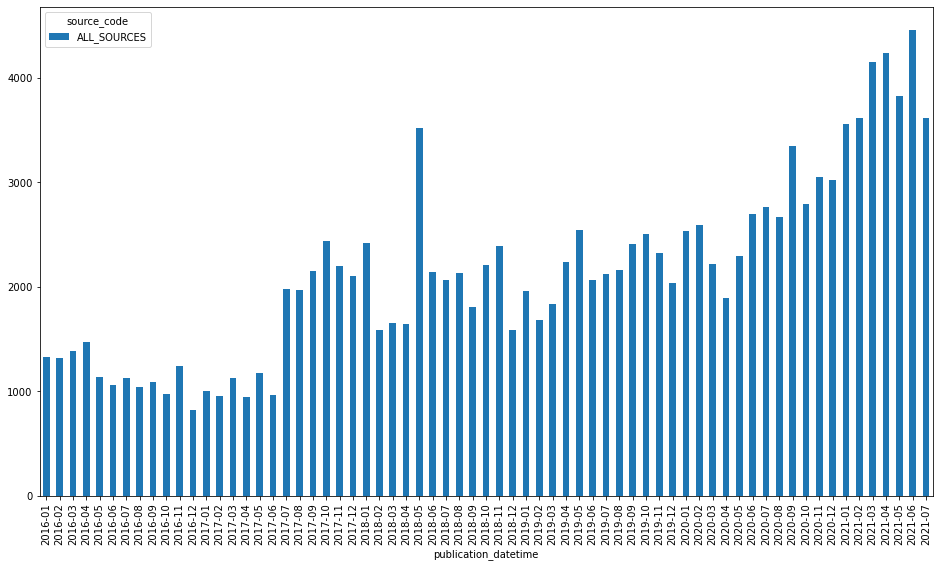

In [12]:
if 'source_code' not in s.last_analytics_job.data.columns:   # To be removed
    s.last_analytics_job.data['source_code'] = 'ALL_SOURCES' # To be removed

stck_data = s.last_analytics_job.data.pivot(index='publication_datetime', columns='source_code', values='count')
stck_data.plot(kind='bar', stacked=True, figsize=(16, 9))